# Entrance Test

In the following tasks, you are guided to solve a multiclassification task to determine the `type` of wheat.

In [1]:
import logging
logger = logging.getLogger('lightning')
logger.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
pl.utilities.distributed.log.setLevel(logging.ERROR)
pl.utilities.seed.log.setLevel(logging.ERROR)

# 1 Preparing Dataset

Before a model can be trained, the dataset has to be loaded, preprocessed and splitted.

## 1.1 Load data

- Read in the csv file `wheat_seeds.csv`, which consists of 199 data instances with 8 features each. 
- Divide the data into X and y:
  - X should be a two-dimensional numpy array with the shape (199,7) derived from all columns except the last.
  - y should be a two-dimensional numpy array with the shape (199,) derived from the last column. This last column contains the `type` value, which we want to determine for unseen
    data in the end.
- Shuffle the data using `sklearn.utils.shuffle`. Set `random_state=0`.

Hints:
- Use pandas to read in the file easily and convert them to a numpy array.
- Use `shape` to check the dimension of a numpy array.

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

data = pd.read_csv("wheat_seeds.csv").to_numpy()

print(data.shape)


X, y = data[:, 0:7], data[:, 7]
X, y = shuffle(X, y, random_state=0)

(199, 8)


## 1.2 Preprocessing

- Take care of NaN/None values in X and y. Replace them simply with zeros here.
- Normalization is most of the time necessary to ensure good convergence in a Neural Network.
Transform X s.t. the values are between 0 and 1.

Hints:
- NaN/None values have to be replaced first.
- Use [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) for the normalization.

In [3]:
from sklearn.preprocessing import MinMaxScaler

X[np.isnan(X)] = 0
y[np.isnan(y)] = 0

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

## 1.3 Splitting

- Split X and y into training and validation data.
- Use the ratio 6:4 for training and validation data, respectively.

Hint: You can use vanilla numpy here.

In [4]:
X_train, y_train = X[:int(len(X)*0.6)], y[:int(len(y)*0.6)]
X_val, y_val = X[int(len(X)*0.6):], y[int(len(y)*0.6):]

# 2 Multi Layer Perceptron

We now want to use our training and validation data to fit a model. As model we use a Neural Network.

## 2.1 Defining Sequential Model

- To implement the model, we use pytorch lightning. Please have a look into the [introductions](https://pytorch-lightning.readthedocs.io/en/latest/starter/new-project.html) to get a short overview.
- Define a [sequential model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) in the following way:
    - The first linear layer should take the number of features from X (already given as `input_units`) as `in_features` and `num_hidden_layers` as `out_features`.
    - The last linear layer should have `output_units` as `out_features`.
    - In between, use `num_hidden_layers` and `num_hidden_units` to set the hidden linear layers and
      their features, respectively.
    - `num_hidden_layers` tells us how many layers should be used and
      `num_hidden_units` how many units in each of these layers are used.
    - After every linear layer, a ReLU as activation function follows.
    - However, please leave out the activation after the last linear layer.

Hint: Use *list to use a list as arguments.

In [5]:
def get_sequential_model(num_hidden_layers,
                         num_hidden_units,
                         input_units,
                         output_units):
    """
    Returns a sequential model with 2+num_hidden_layers linear layers.
    All linear layers (except the last one) are followed by a ReLU function.

    Parameters:
        num_hidden_layers (int): The number of hidden layers.
        num_hidden_units (int): The number of features from the hidden
            linear layers.
        input_units (int): The number of input units.
            Should be number of features.
        output_units (int): The number of output units. In case of regression task,
            it should be one.

    Returns:
        model (nn.Sequential): Neural network as sequential model.
    """

    layers = [nn.Linear(input_units, num_hidden_units), nn.ReLU(),]

    for layer in range(num_hidden_layers):
        layers += [nn.Linear(num_hidden_units, num_hidden_units), nn.ReLU(),]

    layers += [nn.Linear(num_hidden_units, output_units)]

    seq_layers = nn.Sequential(*layers)

    return seq_layers

In [6]:
class PyTorchDataset(Dataset):
    """
    Since we have numpy data, it is required to convert
    them into PyTorch tensors first.
    """

    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        
        self.y = torch.zeros((self.X.shape[0], 1), dtype=torch.float32)
        if y is not None:
            y = y.astype(np.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(pl.LightningModule):
    """
    Multi Layer Perceptron wrapper for pytorch lightning.
    """

    def __init__(self, sequential_model, verbose=False):
        """
        Parameters:
            sequential_model: Underlying Neural Network.
            verbose (bool): If true, the highest val accuracy is plotted after every epoch.
        """

        super().__init__()
        self.verbose = verbose
        self.highest_val_accuracy = 0

        # Important to init the weights the same way
        pl.seed_everything(0)
        self.model = sequential_model
        
        # (Multi-)Classification problem
        self.loss_fn = nn.CrossEntropyLoss() 
    
    def calculate_accuracy(self, y_pred, y_test):
        """
        Calculates the accuracy for `y_pred` and `y_test`.
        """
        
        y_pred_softmax = torch.log_softmax(y_pred, dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)    
        
        correct_pred = (y_pred_tags == y_test).float()
        acc = correct_pred.sum() / len(correct_pred)
        
        return acc

    def validation_step(self, batch, _):
        """
        Receives the validation data and calculates the accuracy on them.

        Parameters:
            batch: Tuple of validation data.

        Returns: 
            metrics (dict): Dict with val accuracy.
        """

        X, y = batch
        y_hat = self.model(X)
        
        val_accuracy = self.calculate_accuracy(y_hat, y)
        return {'val_accuracy': val_accuracy}
    
    def validation_epoch_end(self, outputs):
        """
        Collects the outputs from `validation_step` and sets
        the average for the accuracy.

        Parameters:
            outputs: List of dicts from `validation_step`.
        """

        val_accuracy = torch.stack([o['val_accuracy'] for o in outputs]).numpy().flatten()
        
        val_accuracy = float(np.mean(val_accuracy))
        if val_accuracy > self.highest_val_accuracy:
            self.highest_val_accuracy = val_accuracy
        
        if self.verbose:
            print(f"{self.current_epoch}: {self.highest_val_accuracy}")

    def training_step(self, batch, _):
        """
        Receives the training data and calculates
        cross entropy as loss, which is used to train
        the classifier.

        Parameters:
            batch: Tuple of training data.

        Returns: 
            loss (Tensor): Loss of current step. 

        """

        X, y = batch
        y_hat = self.model(X)

        return self.loss_fn(y_hat, y.long())

    def configure_optimizers(self):
        """
        Configures Adam as optimizer.

        Returns:
            optimizer (torch.optim): Optimizer used internally by
                pytorch lightning.
        """

        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def fit(self, X_train, y_train,
                  X_val, y_val,
                  learning_rate=1e-1,
                  num_epochs=10,
                  batch_size=8):
        """
        Fits the model with training data. Model is validated after every epoch on the validation
        data.
        
        Parameters:
            X_train, y_train: Training data.
            X_val, y_val: Validation data.
            learning_rate (float): Learning rate used in the optimizer.
            num_epochs (int): Number of epochs.
            batch_size (int): How many instances are used to update the weights.
        """
        
        pl.seed_everything(0)
        self.learning_rate = learning_rate
        
        self.trainer = pl.Trainer(
            num_sanity_val_steps=0,  # No validation sanity
            max_epochs=num_epochs,  # We only train one epoch
            progress_bar_refresh_rate=0,  # No progress bar
            weights_summary=None  # No model summary
        )

        # Define training loader
        # `train_loader` is a lambda function, which takes batch_size as input
        train_loader = DataLoader(
            PyTorchDataset(X_train, y_train),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0)

        # Define validation loader
        val_loader = DataLoader(
            PyTorchDataset(X_val, y_val),
            batch_size=1,
            num_workers=0)

        # Train model
        self.trainer.fit(self, train_loader, val_loader)

## 2.2 Training the model

Define the input and the output units and pass them to the `get_sequential_model` function.\
The output units should be determined with the help of `np.unique` since we have one neuron per class. The input
units are the number of used X features. Choose the other parameters as you please.

Afterwards, initialize the `MLP` model with verbose and call its fit method to verify that
everything works.

In [7]:
input_units = X_train.shape[1]
all_labels = np.unique(list(y_train) + list(y_val))
output_units = len(all_labels)

seq_model = get_sequential_model(num_hidden_layers=1, num_hidden_units=5, input_units=input_units, output_units=output_units)

model = MLP(seq_model, verbose=True)
model.fit(X_train, y_train, X_val, y_val)

0: 0.7250000238418579
1: 0.887499988079071
2: 0.887499988079071
3: 0.887499988079071
4: 0.887499988079071
5: 0.887499988079071
6: 0.887499988079071
7: 0.887499988079071
8: 0.9125000238418579
9: 0.925000011920929


# 3 Random Search

In practice, it is often not clear how to choose hyperparameters for a specific problem. Random
search can be used to found a suitable configuration.

## 3.1 Writing Random Search

- Perform random search to find the best configuration for the given multiclassification problem.
- Write a loop that trains a MLP based on the config.
- All results should be saved in the dict `results` with config as key and accuracy as value.

Hints:
- Use model.highest_val_accuracy to judge the performance of a configuration. 
- Access hyperparameters from config with e.g. `config["lr"]`.
- Use all defined hyperparameters.
- Execution may take a minute.

In [8]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from tqdm import tqdm

cs = CS.ConfigurationSpace(seed=0)

learning_rate_hp = CSH.UniformFloatHyperparameter('learning_rate', lower=1e-5, upper=1e-1)
num_hidden_layers = CSH.UniformIntegerHyperparameter('num_hidden_layers', lower=0, upper=4)
num_hidden_units = CSH.UniformIntegerHyperparameter('num_hidden_units', lower=1, upper=int(X_train.shape[1] * 2))
batch_size_hp = CSH.UniformIntegerHyperparameter('batch_size', lower=8, upper=int(len(X_train)))
cs.add_hyperparameters([learning_rate_hp, num_hidden_layers, num_hidden_units, batch_size_hp])

results = {}
for config in tqdm(cs.sample_configuration(25)):
    sequential_model = get_sequential_model(
        num_hidden_layers=config["num_hidden_layers"],
        num_hidden_units=config["num_hidden_units"],
        input_units=input_units,
        output_units=output_units)

    model = MLP(sequential_model)
    model.fit(X_train, y_train, X_val, y_val, batch_size=config["batch_size"], learning_rate=config["learning_rate"])
    
    results[config] = model.highest_val_accuracy

100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


## 3.2 Plotting

- Print the best and the worst configuration with their corresponding performance.
- Use matplotlib to plot a step function (use `x` and `y`), showing the highest accuracy found so far over time (in our case: number of evaluated configurations).
- Make sure the steps are placed "post".

Hints:
- Use the results dict from the exercise before.
- Have a look into the [API](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.step.html).

Found best Configuration:
  batch_size, Value: 67
  learning_rate, Value: 0.061213451315014926
  num_hidden_layers, Value: 0
  num_hidden_units, Value: 8
 with 94.9999988079071%.
Found worst Configuration:
  batch_size, Value: 95
  learning_rate, Value: 0.006031944908210691
  num_hidden_layers, Value: 4
  num_hidden_units, Value: 11
 with 30.000001192092896%.


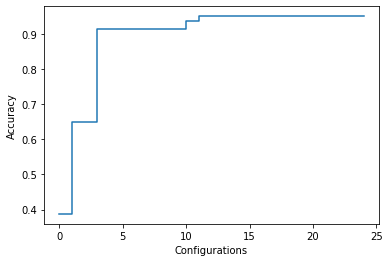

In [10]:
import matplotlib.pyplot as plt

x = []
y = []

config_list = list(results.keys())
accuracy_list = list(results.values())

best = np.argmax(np.array(accuracy_list))
worst = np.argmin(np.array(accuracy_list))

highest_accuracy = accuracy_list[best]
lowest_accuracy = accuracy_list[worst]

best_config = config_list[best]
worst_config = config_list[worst]

current_lowest_accuracy = lowest_accuracy
for idx, (config, accuracy) in enumerate(results.items()):
    x += [idx]
    if accuracy > current_lowest_accuracy:
        current_lowest_accuracy = accuracy
        
    y += [current_lowest_accuracy]
    
plt.step(x, y, where='post')
plt.xlabel("Configurations")
plt.ylabel("Accuracy")

print(f"Found best {best_config} with {highest_accuracy*100}%.")
print(f"Found worst {worst_config} with {lowest_accuracy*100}%.")